# Transfer Learning Approach with Pretrained Model (EfficientNet)

In [2]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras

from keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

## Load Dataset

Read the test and training data into variables. Images are already processed here, i.e. correctly sized, converted to numpy arrays and preprocessed similir to EfficientNet.

In [3]:
train_dir = './ds/train/'
test_dir = './ds/test/'

classes = [os.path.basename(x[0]) for x in os.walk(train_dir) if x[0]][1:]
num_classes = len(classes)
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [4]:
def load_data(path):
    data = []
    for c, category in enumerate(classes):
        images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path + category) for f in filenames]

        for img_path in images:
            # Note that we apply the same preprocessing and target images of size 224x224
            # in order to match the setup of original EfficientNet model
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            data.append({'x' : np.array(x[0]), 'y' : c})

    return data


data_train_val = load_data(train_dir)
data_test = load_data(test_dir)

In [5]:
X_train_val, y_train_val = np.array([t["x"] for t in data_train_val]), [t["y"] for t in data_train_val]
X_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.2)

# Convert classes to one-hot vectors
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Train images:', len(y_train), y_train.shape)
print('Val images:', len(y_val), y_val.shape)
print('Test images:', len(y_test), y_test.shape)


Train images: 872 (872, 21)
Val images: 219 (219, 21)
Test images: 279 (279, 21)


## Data Enhancement

#### Balance classes

The imbalance in the training data is now reduced. Class weights are used to let the CNN pay special attention to classes that are underrepresented.

In [6]:
# Compute class weights to let the CNN pay attention to less frequent classes when fitting the model
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_integers),
                                     y=y_integers)
class_weights = dict(zip(np.unique(y_integers), class_weights))

#### Generate artificial images using shift, rotation, flip

Use an ImageDataGenerator to slightly change images in each epoch. Note that this is only done to training data, but not to validation data.

In [7]:
# Enrich train data set by rotation, flip, shift
gen_train = ImageDataGenerator(rotation_range=5,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               data_format='channels_last',
                               preprocessing_function=preprocess_input)

# No augmentation for test and validation sets
gen_val_test = ImageDataGenerator(data_format='channels_last',
                                  preprocessing_function=preprocess_input)

# Generate iterators for train/val/test sets
train_iter = gen_train.flow(X_train, y_train, batch_size=16)
val_iter = gen_val_test.flow(X_val, y_val, batch_size=16)
test_iter = gen_val_test.flow(X_test, y_test, batch_size=16)


## Model Creation and Training

Create a CNN model using multiple convolutional layers. As opposed to constant a number of filters in each convolutional layer, this model increases number of filters in deeper layers as more complex features can be learned.

In [ ]:
def get_model():

    base_model = EfficientNetB0(weights='imagenet',
                          include_top=False,
                          input_shape=X_train.shape[1:],
                          classes=num_classes)
    
    # Freeze pretrained model weights
    base_model.trainable = False
    inputs = keras.Input(shape=X_train.shape[1:])

    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax', name='pred')(x)

    return keras.Model(inputs, outputs)


In [ ]:
tl_model = get_model()
tl_model.summary()

tl_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [ ]:
# Create checkpoints during training
filepath = './models/transfer/transfer_{epoch:02d}_{val_accuracy:.2f}.hdf5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

callbacks_list = [checkpoint, lr]

# Train the model
history = tl_model.fit(train_iter,
                    epochs=25,
                    validation_data=val_iter,
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    workers=3)

#### Visualize training progress along epochs

Plot the (val_)accuracy and (val_)loss along epochs to identify over- and underfitting.

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label='validation')
ax.plot(history.history["loss"], label='train')
ax.legend(loc="upper right")
ax.set_title("Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label='validation')
ax2.plot(history.history["accuracy"], label='train')
ax2.legend(loc="lower right")
ax2.set_title("Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

## Evaluation

#### Analysis of model performance on test data

In [9]:
# NOTE: By default, the finished model is loaded from the repository in order to evaluate
# without compiling and fitting the model again. However, if you train again,
# uncomment the following line and comment the load_model() call below

# test_model = tl_model
test_model = keras.models.load_model('./models/transfer/transfer_ep=08_acc=83.h5')

y_pred = test_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

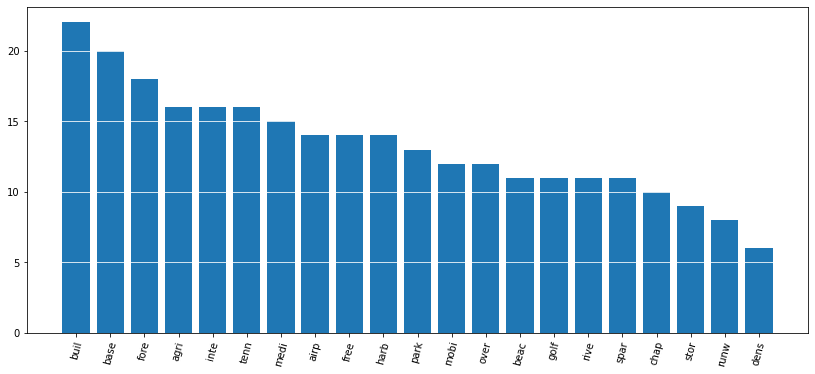

In [10]:
# Plot the distribution of predicted classes

unique, counts = np.unique(y_pred, return_counts=True)
ticks = np.arange(len(counts))
pred_dist = sorted(zip(classes, counts), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, [c[1] for c in pred_dist])
plt.xticks(ticks, [c[0][:4] for c in pred_dist], rotation=75)
plt.show()

Acc:  0.8315412186379928
Prec:  0.864981354766301
Rec:  0.8315412186379928


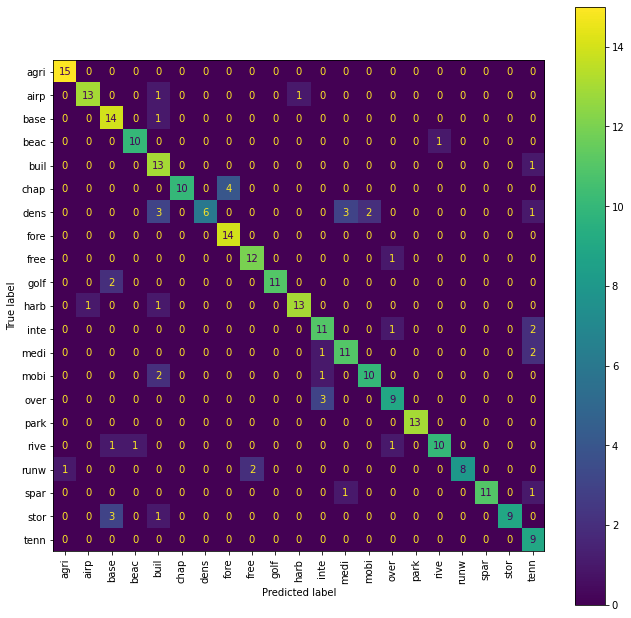

In [11]:
cm = confusion_matrix(y_true, y_pred)
cm = np.round(cm, 2)

cmd = ConfusionMatrixDisplay(cm, display_labels=[c[:4] for c in classes])

fig, ax = plt.subplots(figsize=(11,11))
cmd.plot(ax=ax, xticks_rotation='vertical')

print('Acc: ', accuracy_score(y_true, y_pred))
print('Prec: ', precision_score(y_true, y_pred, average='weighted'))
print('Rec: ', recall_score(y_true, y_pred, average='weighted'))
# Acc:  0.8315412186379928
# Prec:  0.864981354766301
# Rec:  0.8315412186379928